# Q-Learning Trading

Ora creiamo un agente che si aggiorna con l'algoritmo Q-learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
df0 = pd.read_csv("sp500_closefull.csv", index_col=0, parse_dates=True)
df0 = df0.dropna(axis=0, how="all")
df0 = df0.dropna(axis=1, how="any")

In [3]:
data = {}
for name in df0.columns:
  data[name] = np.log(df0[name]).diff()
df_returns = pd.DataFrame(data=data)

In [4]:
N_test = 1000
train_data = df_returns[:-N_test]
test_data = df_returns[-N_test:]

In [5]:
# Useremo il binning. Per ogni azione useremo 10 bin.
# Questo significa che avremo 10 stati per ogni azione e l'incremento dello state space è esponenziale: 10^n_azioni
features = ["AAPL", "MSFT", "AMZN"]

In [6]:
class Env:
    def __init__(self, df):
        self.df = df
        self.n = len(df)
        self.current_index = 0
        self.action_space = [0, 1, 2]
        self.invested = 0

        self.states = self.df[features].to_numpy()
        self.rewards = self.df["SPY"].to_numpy()

    def reset(self):
        self.invested = 0
        self.current_idx = 0
        return self.states[self.current_idx]

    def step(self, action):
        self.current_idx += 1
        if self.current_idx >= self.n:
            raise Exception("Episode Already Finished")

        if action == 0: # If Buy
            self.invested = 1
        elif action == 1: # If Sell
            self.invested = 0

        # Compute Reward
        if self.invested:
            reward = self.rewards[self.current_idx]
        else:
            reward = 0

        next_state = self.states[self.current_idx]

        # done
        done = (self.current_idx == self.n-1)

        return next_state, reward, done        

In [7]:
class StateMapper:

    def __init__(self, env, n_bins=6, n_samples=10000):
        # L'idea del costruttore della classe è quella di avere tot campioni dall'env per stimare la frequenza e creare i bin
        # Per farlo, vaghiamo randomicamente nell'env attraverso random actions per raccogliere campioni
        # dopo averlo fatto, creiamo i boundaries per i nostri bin.
        states = []
        done = False
        s = env.reset()
        self.D = len(s) # Cerchiamo quante variabili dobbiamo binnare.
        states.append(s)

        for _ in range(n_samples):
            a = np.random.choice(env.action_space)
            s2, _, done = env.step(a)
            states.append(s2)
            if done:
                s = env.reset()
                states.append(s)

        states = np.array(states)
        
        self.bins = []
        for d in range(self.D):
            column = np.sort(states[:,d])
            # il current_bin si salva tutti i boundaries del singolo bin (colonna)
            current_bin = []
            for k in range(n_bins):
                boundary = column[int(n_samples / n_bins * (k+0.5))]
                current_bin.append(boundary)
            self.bins.append(current_bin)

    def transform(self, state):
        # trasforma uno stato nella tupla di bin corrispondente
        x = np.zeros(self.D)
        for d in range(self.D):
            # Assegnamo la d-ma colonna dello stato al corrispettivo bin
            x[d] = int(np.digitize(state[d], self.bins[d]))
        return tuple(x)

    def all_possible_states(self):
        # Dato che la Q-Table si aggiorna iterativamente, abbiamo bisogno di uno stato iniziale.
        # Questa funzione ci dice la dimensione dello stato iniziale
        list_of_bins = []
        for d in range(self.D):
            list_of_bins.append(list(range(len(self.bins[d]) + 1))) # crea una lista di elementi da 0 a len(bins) incluso estremo
        # Itertools.product crea un product object ed in input chiede un puntatore ad una lista di liste
        # Se trasformi l'output in lista, è la combinazione degli elementi passati in input, forniti come tupla.
        # Questo ci da la lista di tutti i possibili stati
        return itertools.product(*list_of_bins)
        
        
            

In [8]:
class Agent:
    def __init__(self, action_size, state_mapper):
        self.action_size = action_size
        self.gamma = 0.8 # Discount rate
        self.epsilon = 0.1 # epsilon-greedy
        self.learning_rate = 1e-1 # alpha per la Q-table update
        self.state_mapper = state_mapper

        # initialize Q-table
        self.Q = {}
        for s in self.state_mapper.all_possible_states():
            s = tuple(s)
            for a in range(self.action_size):
                self.Q[(s, a)] = np.random.randn() # Q[((b1, b2, b3), a)] = random number da random distribution


    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)

        s = self.state_mapper.transform(state)
        act_values = [self.Q[(s, a)] for a in range(self.action_size)] # mette i valori in una riga
        return np.argmax(act_values) # ritorna argmax


    def train(self, state, action, reward, next_state, done):
        s = self.state_mapper.transform(state)
        s2 = self.state_mapper.transform(next_state)

        if done:
            target=reward
        else:
            act_values = [self.Q[(s2, a)] for a in range(self.action_size)]
            target = reward + self.gamma * np.amax(act_values)

        self.Q[(s,action)] += self.learning_rate * (target -  self.Q[(s,action)])                
        

In [9]:
def play_one_episode(env, agent, is_train):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        if is_train:
            agent.train(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    return total_reward

In [10]:
num_episodes = 500 # episodes to train agent

In [11]:
train_env = Env(train_data)
test_env = Env(test_data)

In [12]:
action_size = len(train_env.action_space)
state_mapper = StateMapper(train_env)
agent = Agent(action_size, state_mapper)

In [13]:
train_rewards = np.empty(num_episodes)
test_rewards = np.empty(num_episodes)

In [14]:
for e in range(num_episodes):
    r = play_one_episode(train_env, agent, is_train=True)
    train_rewards[e] = r

    tmp_epsilon = agent.epsilon
    agent.epsilon = 0. # settiamo l'agent per fare sempre le scelte migliori
    r_test = play_one_episode(test_env, agent, is_train=False)
    agent.epsilon = tmp_epsilon
    test_rewards[e] = r_test

    print(f"eps: {e+1}/{num_episodes}, train: {r:.5f}, test:{r_test:.5f}")

eps: 1/500, train: 0.26472, test:0.09459
eps: 2/500, train: 0.47524, test:0.08459
eps: 3/500, train: 0.18762, test:0.07735
eps: 4/500, train: 0.30749, test:0.07873
eps: 5/500, train: 0.32455, test:0.08909
eps: 6/500, train: 0.15444, test:-0.00604
eps: 7/500, train: 0.32348, test:0.00744
eps: 8/500, train: 0.23913, test:0.04283
eps: 9/500, train: 0.45482, test:-0.03145
eps: 10/500, train: 0.31520, test:0.05311
eps: 11/500, train: 0.44910, test:0.06201
eps: 12/500, train: 0.20811, test:0.02790
eps: 13/500, train: 0.26512, test:0.03979
eps: 14/500, train: 0.33894, test:-0.12003
eps: 15/500, train: 0.25148, test:-0.02705
eps: 16/500, train: 0.41454, test:0.02713
eps: 17/500, train: 0.43185, test:0.03920
eps: 18/500, train: 0.12253, test:0.00171
eps: 19/500, train: 0.15278, test:0.14053
eps: 20/500, train: 0.01263, test:-0.18417
eps: 21/500, train: 0.39111, test:0.12930
eps: 22/500, train: 0.30621, test:-0.06536
eps: 23/500, train: 0.22891, test:0.22001
eps: 24/500, train: 0.39477, test:0.0

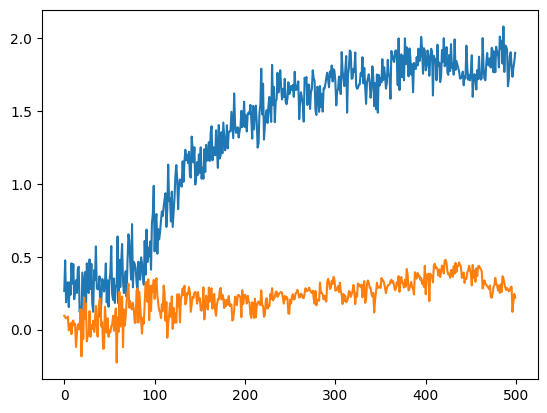

In [15]:
plt.plot(train_rewards)
plt.plot(test_rewards)